**Note:**

This version attempts to only uses correctable syndromes. However to create those all posible errors idealy has to be checked which is only possible for small distance surface codes. This is done by creating random errors and calculating both their biased distance and logicals and storing that information. If the same syndrome is then seen again, its distance will be compared with the distance of the already seen syndrome. If smaller the information will be overwritten with the new information ortherwise the new information will be discarded. This ensures that only the logicals from the most likely seen cause of that syndrome will be used and thus ensures that the same syndrome will always result in the same logical during the training process eliminating possible confusion for the neaural network.

In [1]:
# Allows us to import files from the base folder
import sys
import os
# Get the parent directory of the notebook's folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(base_dir)

# Imports
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit, value_and_grad
import optax

import numpy as np

from pymatching import Matching

import matplotlib.pyplot as plt

from packages.quantum_error_correction import *
from packages.neural_network import *

from icecream import ic  # For debugging

key = jax.random.key(42)

# Initialize the QEC code that will be used

Rate of non-trivial cases: 99.99%


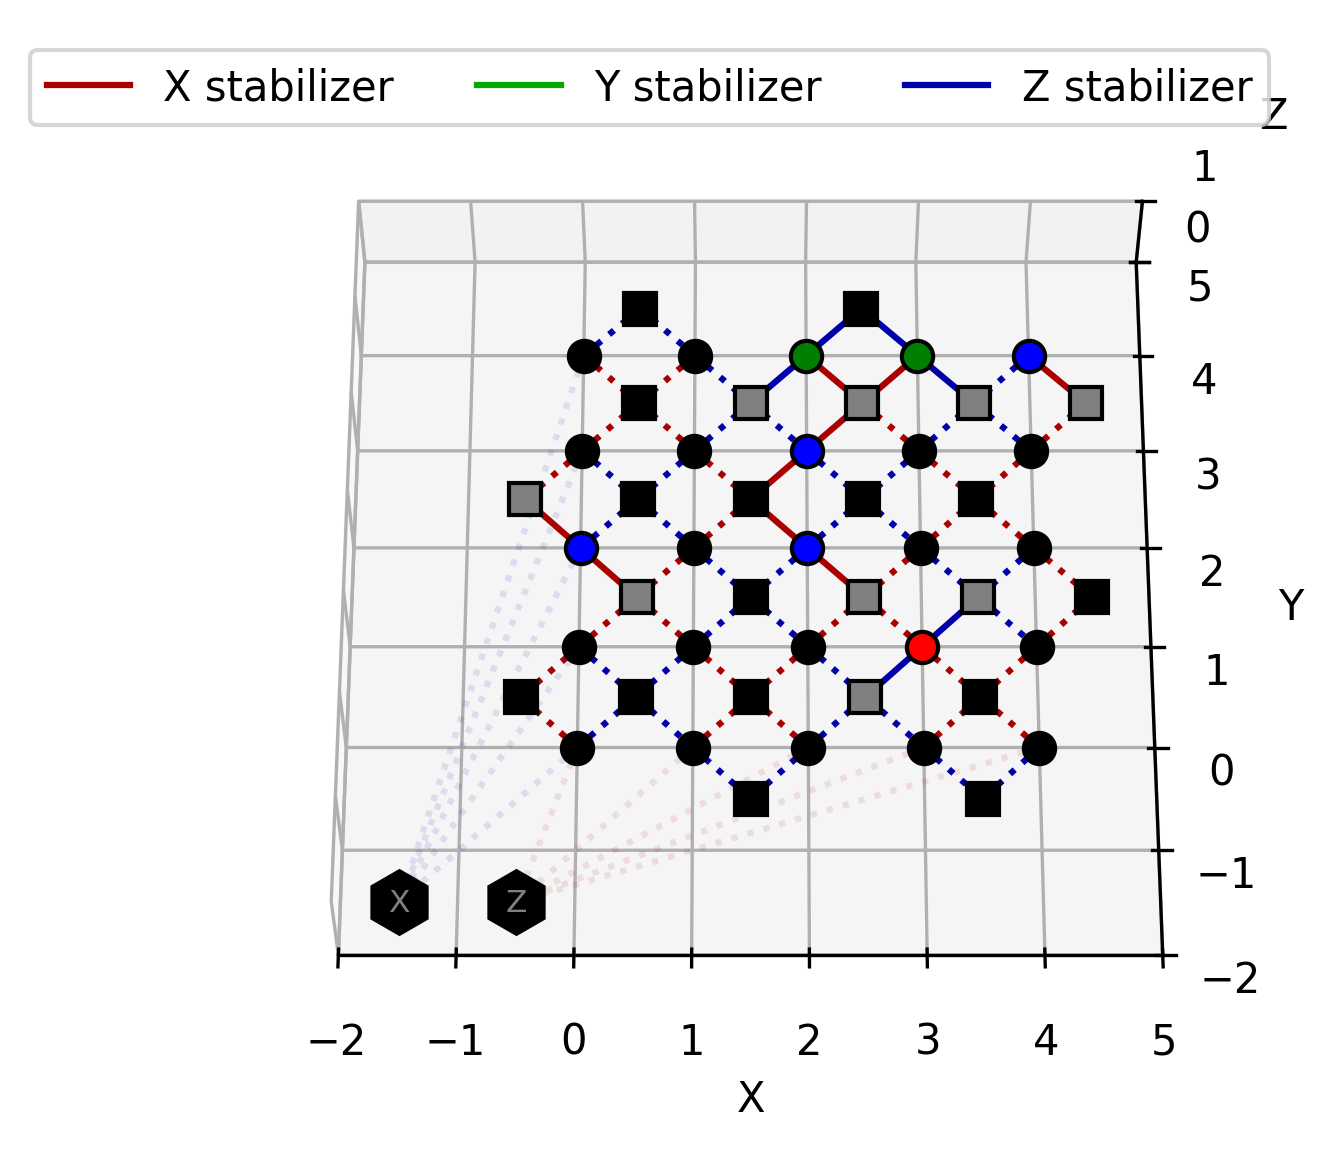

In [2]:
error_prob = [.1, .1, .1]
code_distance = 5

subkey, key = jax.random.split(key)
errors = jax_create_error_batch(*error_prob, size=code_distance**2, batch_size=1, key=subkey)

qec = QEC(surface_code_data_wls(d=code_distance))
info = {}
info['Mx'], info['My'], info['Mz'] = qec.transformation_matrix()
# Split into matrix for syndrome qubits in logical detectors
info['Sx'], info['Lx'] = info['Mx'][:-2], info['Mx'][-2:]
info['Sy'], info['Ly'] = info['My'][:-2], info['My'][-2:]
info['Sz'], info['Lz'] = info['Mz'][:-2], info['Mz'][-2:]
nsq, ndq = info['Sx'].shape
qec.show(errors=errors[0]);

print(f'Rate of non-trivial cases: {1-(1-sum(error_prob))**ndq:.2%}')

syndromes = jax_get_syndromes_batch(info['Sx'], info['Sy'], info['Sz'], errors)
logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], errors)

# Find all correctable syndromes

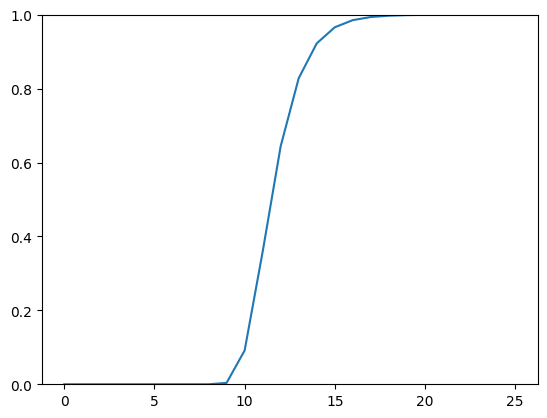

In [3]:
from scipy.stats import binom
from scipy.special import comb

x = jnp.arange(0, ndq+1)
y = binom.pmf(x, n=ndq, p=3*.1)
c = comb(ndq, x)*3
p = y / c

plt.figure()
plt.plot(x, (1-p)**(1E6*256))
plt.ylim(0, 1)
plt.show()

In [4]:
error_prob = [.01, .01, .01]
cost = jnp.log(jnp.array([1, *error_prob])) / jnp.log(max(error_prob))
upd = []

syndrome_min_distance = jnp.ones(shape=(2**nsq))*jnp.inf
syndrome_logicals = jnp.zeros(shape=(2**nsq, 2), dtype=bool)

In [5]:
batch_size = 1_000_000

for i in range(256):
    try:
        subkey, key = jax.random.split(key)
        errors = jax_create_error_batch(px=.1, py=.1, pz=.1, size=code_distance**2, batch_size=batch_size, key=subkey)
        syndromes = jax_get_syndromes_batch(info['Sx'], info['Sy'], info['Sz'], errors)
        logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], errors).astype(bool)

        syndrome_distances = cost[errors].sum(axis=1)

        powers = 2**jnp.arange(0, nsq)
        syndrome_ids = syndromes.dot(powers)

        updates = (syndrome_min_distance[syndrome_ids] > syndrome_distances).sum()
        upd.append(updates)
        syndrome_min_distance = syndrome_min_distance.at[syndrome_ids].min(syndrome_distances)

        update_locations = jnp.where(syndrome_min_distance[syndrome_ids] == syndrome_distances)
        syndrome_logicals = syndrome_logicals.at[syndrome_ids[update_locations]].set(logicals[update_locations])

        print(f"{i}: Updated {updates:7d} ({updates/batch_size:7.2%}) of the entries", end='\r')
    except KeyboardInterrupt:
        break

In [6]:
subkey, key = jax.random.split(key)
errors = jax_create_error_batch(*error_prob, size=code_distance**2, batch_size=batch_size, key=subkey)
syndromes = jax_get_syndromes_batch(info['Sx'], info['Sy'], info['Sz'], errors)
logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], errors).astype(bool)

syndrome_distances = cost[errors].sum(axis=1)

powers = 2**jnp.arange(0, nsq)
syndrome_ids = syndromes.dot(powers)

updates = (syndrome_min_distance[syndrome_ids] > syndrome_distances).sum()
upd.append(updates)
syndrome_min_distance = syndrome_min_distance.at[syndrome_ids].min(syndrome_distances)

update_locations = jnp.where(syndrome_min_distance[syndrome_ids] == syndrome_distances)
syndrome_logicals = syndrome_logicals.at[syndrome_ids[update_locations]].set(logicals[update_locations])

print(f"Check: Updated {updates:7d} ({updates/batch_size:7.2%}) of the entries for {error_prob = }", end='\r')

# Create data function

In [7]:
def jax_create_error_batch(px: float, py: float, pz: float, size: int, batch_size: int, key) -> jnp.ndarray:
    rand = jax.random.uniform(key, shape=(batch_size, size))
    result = jnp.zeros_like(rand, dtype=jnp.int32)  # Initialize with zeros (default case)

    # Apply conditions sequentially
    result = jnp.where(rand < px + py + pz, 1, result)  # Check for px+py+pz first
    result = jnp.where(rand < py + pz, 2, result)      # Check for py+pz next
    result = jnp.where(rand < pz, 3, result)          # Check for pz last

    return result

def gen_data(error_prob: list, info: dict, ndq: int, batch_size: int, key):
    errors = jax_create_error_batch(*error_prob, size=ndq, batch_size=batch_size, key=key)
    syndrome_distances = cost[errors].sum(axis=1)

    syndromes = jax_get_syndromes_batch(info['Sx'], info['Sy'], info['Sz'], errors)
    logicals_c = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], errors)
    
    powers = 2**jnp.arange(0, nsq)
    syndrome_ids = syndromes.dot(powers)
    logicals_l = syndrome_logicals[syndrome_ids].astype(int)

    logicals = jnp.where((syndrome_min_distance[syndrome_ids] < syndrome_distances)[:,None], logicals_c, logicals_l)

    # for a, b, c, d in  zip(logicals_c, logicals_l, syndrome_min_distance[syndrome_ids], syndrome_distances):
    #     print(a,b,jnp.array_equal(a,b),'|',c,d)
    return syndromes, logicals

subkey, key = jax.random.split(key)
syndromes, logicals = gen_data(error_prob, info, ndq, batch_size=10, key=subkey)
print("Syndromes:")
print(syndromes)
print("\nLogicals:")
print(logicals)

Syndromes:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0]]

Logicals:
[[0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]]


# Create the NN

In [8]:
def NN(x, params):
    # Change from 0, 1 inputs to -1, 1
    x = 2*x - 1

    num_layers = len(params['weights'])
    for layer_idx, (w, b) in enumerate(zip(params['weights'], params['biases'])):
        x = jnp.matmul(w, x) + b
        if layer_idx < num_layers-1:
            x = jax.nn.relu(x)
    return x


NN_batch = jax.vmap(NN, in_axes=[0, None], out_axes=0)

# Initialize the NN
with random weights and biases

In [9]:
subkey, key = jax.random.split(key)
num_neurons_layers = [nsq, 32, 16, 8, 4, 2]
params = NN_init_params( subkey, num_neurons_layers )
print(f"Layers: {num_neurons_layers}")

b_count = 0
for b in params['biases']:
    b_count += b.shape[0]
print(f'Bias parameters: {b_count}')

w_count = 0
for w in params['weights']:
    w_count += w.shape[0] * w.shape[1]
print(f'Weight parameters: {w_count}')

print(f'Total: {b_count+w_count}')

Layers: [24, 32, 16, 8, 4, 2]
Bias parameters: 62
Weight parameters: 1448
Total: 1510


# Cost function

In [10]:
def mse_loss_batch(NN_input: jnp.ndarray, params: dict, logicals: jnp.ndarray) -> jnp.ndarray:
    """
    Uses the Binary Cross Entropy (BCE) to evaluate the performance of the NN
    """
    NN_logicals = NN_batch(NN_input, params)
    return optax.sigmoid_binary_cross_entropy(NN_logicals, logicals).mean()

mse_loss_batch_val_grad = value_and_grad(mse_loss_batch, argnums=1)
mse_loss_batch_val_grad = jax.jit(mse_loss_batch_val_grad)

# Test it on the randomly initiated NN

In [11]:
# Generate data
subkey, key = jax.random.split(key)
syndromes, logicals = gen_data(error_prob, info, ndq, batch_size=1000, key=subkey)

# Run the neural network
NN_probs = jax.nn.sigmoid(NN_batch(syndromes, params))
NN_logicals = jnp.where(NN_probs>0.5, 1, 0)
print(NN_probs)

# Evaluate the neural networks performance
mse_loss_batch(syndromes, params, logicals)

[[0.59429157 0.5395837 ]
 [0.51833147 0.49307454]
 [0.51833147 0.49307454]
 ...
 [0.5498944  0.48110378]
 [0.51833147 0.49307454]
 [0.5384644  0.5097749 ]]


Array(0.70670176, dtype=float32)

# Train the NN

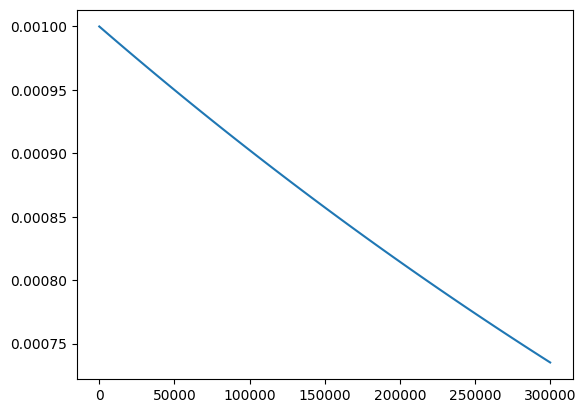

In [35]:
init_value = 1E-3
transition_steps = 50_000
decay_rate = 0.95

count = jnp.linspace(0, 300_000)

rate_factor = count / transition_steps
decayed_value = init_value * (decay_rate ** rate_factor)

plt.figure()
plt.plot(count, decayed_value)
plt.show()

learning_rate = optax.exponential_decay(
    init_value = 1E-3,
    transition_steps = 50_000,
    decay_rate = 0.95
)
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

losses=[]
idx_batch = 0
T = {
    'Data generation ': 0, 
    'loss + grad calc': 0, 
    'Safe guard      ': 0, 
    'Update          ': 0, 
    'Store           ': 0}

In [37]:
print(error_prob)

# training parameters
max_training_batches = 1_000_000
max_training_time = 60*60 # in seconds
batch_size = 32

num_batch_generation_size = 100_000 // batch_size
print(num_batch_generation_size)

subkey, key = jax.random.split(key)
syndromes_, logicals_ = gen_data(error_prob, info, ndq, batch_size=num_batch_generation_size*batch_size, key=subkey)

[0.01, 0.01, 0.01]
3125


In [40]:
from IPython.display import clear_output
from time import time

start = time()

while True: 
    try:
        t0 = time()

        # Generate data
        if idx_batch % num_batch_generation_size == 0:
            if idx_batch > 0:
                s = 20000
                skip = 10
                losses_ = losses[-2*s-1::skip]
                improvement_rate, _ = np.polyfit(skip*np.arange(0,len(losses_),1), losses_, deg=1)
                score = np.mean(losses_)
                print(f"{score = :7.5f} with an improvement rate of {improvement_rate:9.2E} | grad/val = {improvement_rate/score*num_batch_generation_size:7.5f} | Learning rate = {init_value * (decay_rate**(idx_batch / transition_steps)):9.2E} | {idx_batch = }")
                # if improvement_rate > 0: # No improvement seen in the last 2s rounds of training
                #     print("Training has platoed.")
                #     break
            subkey, key = jax.random.split(key)
            syndromes_, logicals_ = gen_data(error_prob, info, ndq, batch_size=num_batch_generation_size*batch_size, key=subkey)
        syndromes = syndromes_[(idx_batch%num_batch_generation_size)*batch_size:((idx_batch%num_batch_generation_size)+1)*batch_size]
        logicals = logicals_[(idx_batch%num_batch_generation_size)*batch_size:((idx_batch%num_batch_generation_size)+1)*batch_size]

        t1 = time()
        T['Data generation '] += t1 - t0
        t0 = t1
        
        # get loss and its gradient with respect to network parameters:
        loss, grads = mse_loss_batch_val_grad(syndromes, params, logicals)

        t1 = time()
        T['loss + grad calc'] += t1 - t0
        t0 = t1

        # Safe-guard against nan values
        # Stops the training before updating with problematic prams
        if jnp.isnan(loss) or any([jnp.isnan(bias).any() for bias in grads['weights']]):
            print('Got nan values at batch id:', idx_batch)
            break
        # if time() - start > max_training_time:
        #     print('Surpassed the specified training time')
        #     break

        t1 = time()
        T['Safe guard      '] += t1 - t0
        t0 = t1

        # update the network parameters:
        updates, opt_state = optimizer.update( grads, opt_state )
        params = optax.apply_updates( params, updates )

        t1 = time()
        T['Update          '] += t1 - t0
        t0 = t1

        # add the loss to the list:
        losses.append(loss)
        idx_batch += 1

        t1 = time()
        T['Store           '] += t1 - t0
        t0 = t1
    except KeyboardInterrupt:
        print('Manually stopped')
        break


score = 0.00844 with an improvement rate of -1.71E-08 | grad/val = -0.00634
score = 0.00919 with an improvement rate of -4.81E-08 | grad/val = -0.01635
score = 0.00832 with an improvement rate of -2.48E-08 | grad/val = -0.00932
score = 0.00881 with an improvement rate of -4.13E-08 | grad/val = -0.01465
score = 0.00821 with an improvement rate of  2.54E-09 | grad/val = 0.00097
Training has platoed.


In [41]:
for k,v in T.items():
    print(f"{k}: {v:10.3f}s ({v/sum(T.values()):6.2%})")

Data generation :    118.178s ( 5.21%)
loss + grad calc:     35.443s ( 1.56%)
Safe guard      :    130.703s ( 5.76%)
Update          :   1980.283s (87.35%)
Store           :      2.576s ( 0.11%)


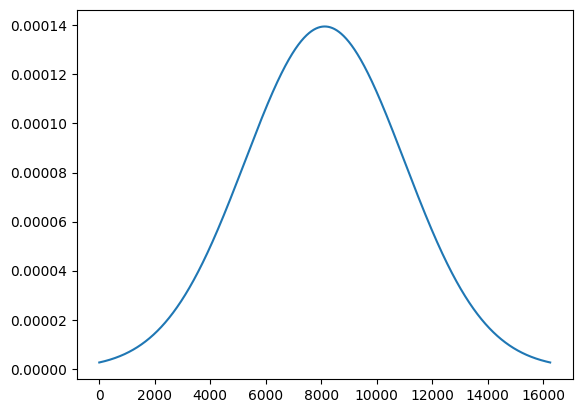

In [42]:
window_size = len(losses) // 20
window_xs = np.linspace(-2, 2, window_size)
window_form = jnp.exp(-window_xs**2)
window = window_form / sum(window_form)

plt.plot(range(window_size), window)

In [43]:
losses_jax = jnp.array(losses)
losses_ = jnp.ones(shape=(losses_jax.shape[0]+2*window_size))
a = window_size
b = a + losses_jax.shape[0]
losses_ = losses_.at[a:b].set(losses_jax)
losses_ = losses_.at[:a].set(losses_jax[:a][::-1])
losses_ = losses_.at[b:].set(losses_jax[-a:][::-1])
running_avg = jnp.convolve(losses_, window, mode='same')[a:b]

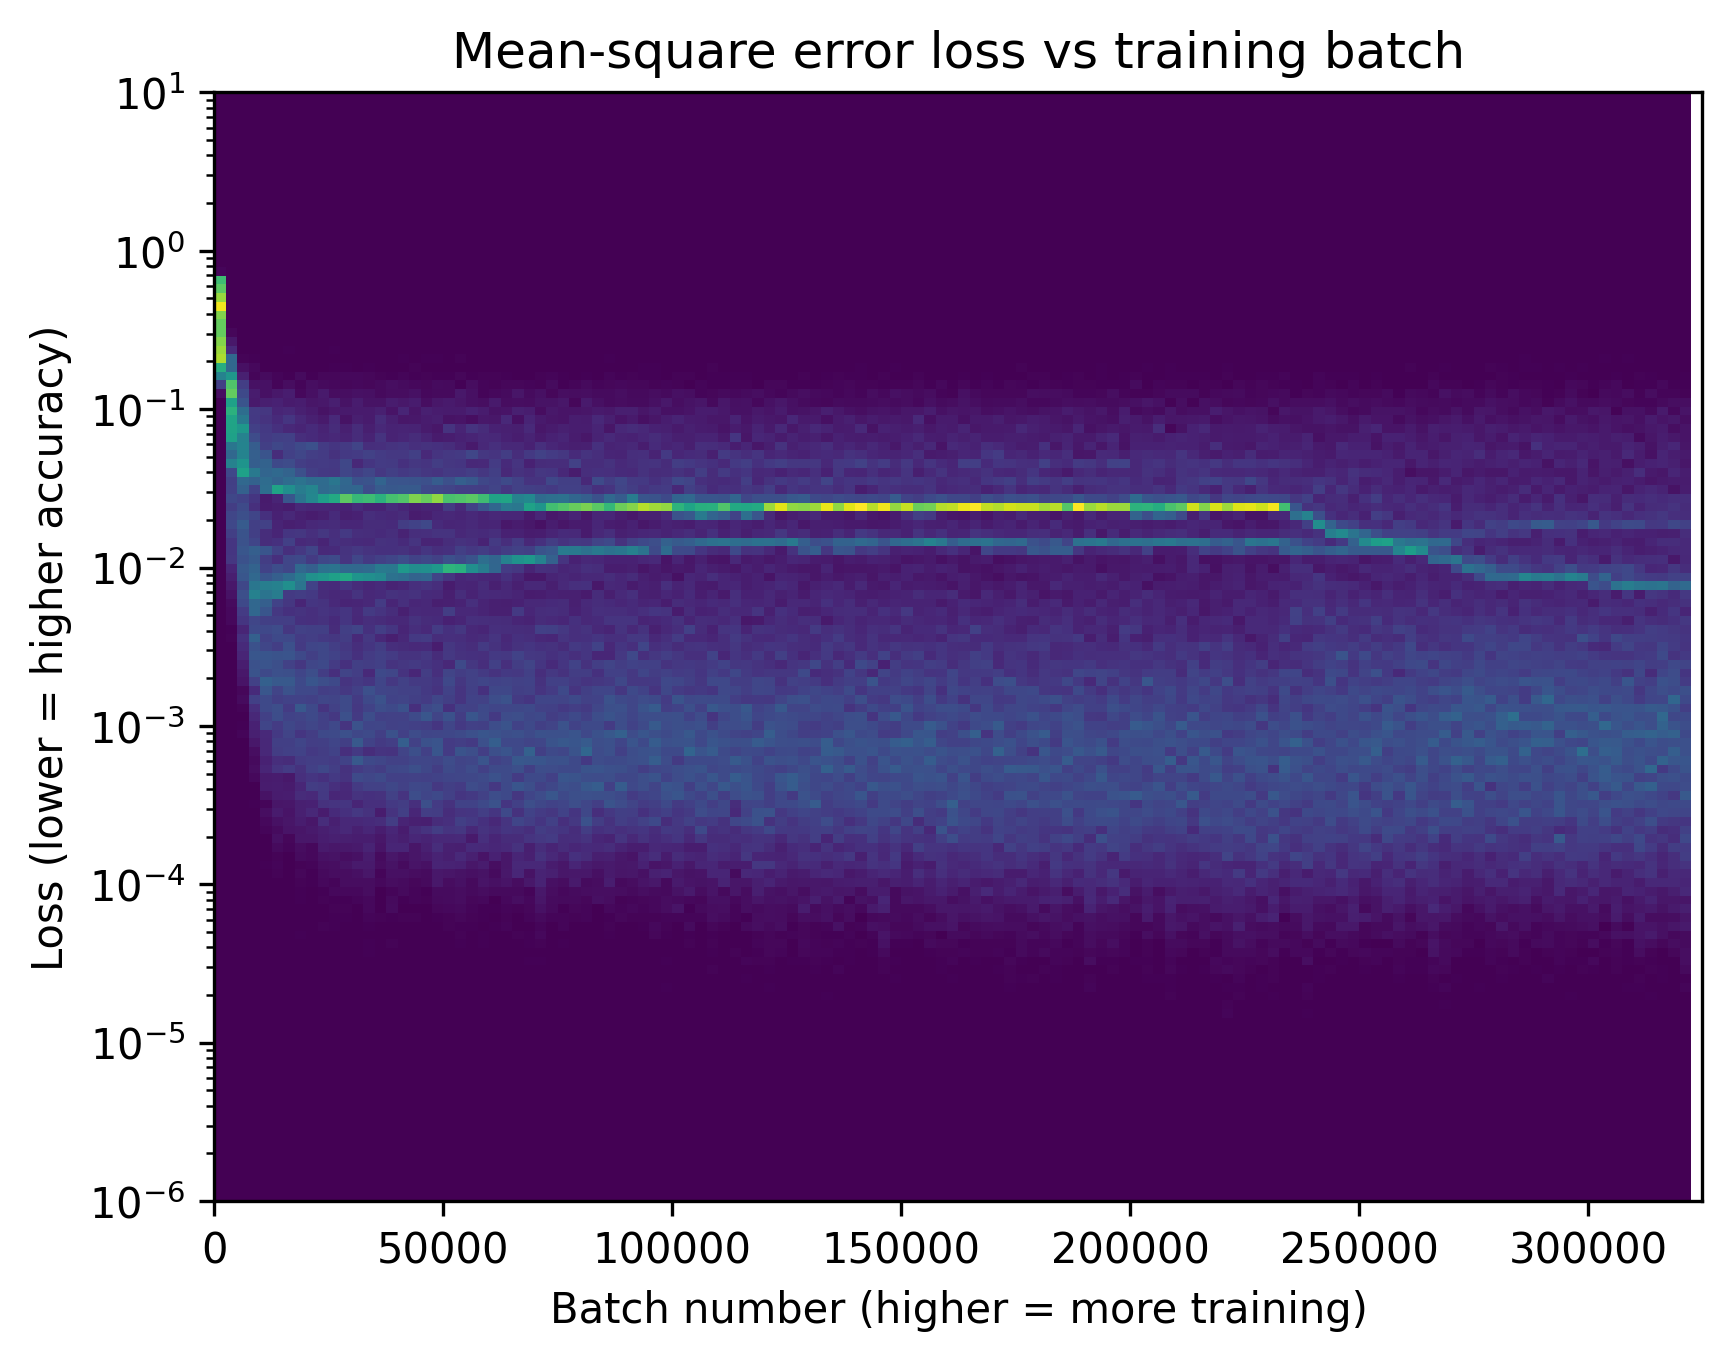

In [44]:
plt.figure(dpi=300)
# plt.plot(jnp.arange(0, len(losses)), losses, ',', label="Raw data")
# plt.plot(jnp.arange(0, len(losses)), running_avg, label="Running AVG", c='k')
plt.hist2d(jnp.arange(0, len(losses)), losses_jax, bins=(
    jnp.arange(0, len(losses), 2_500),
    jnp.logspace(-6, 1, 128)
), cmap='viridis')
plt.xlim(0, len(losses))
# plt.ylim(ymin = running_avg.min())
# plt.legend()
plt.yscale( "log" )
plt.title("Mean-square error loss vs training batch")
plt.xlabel("Batch number (higher = more training)")
plt.ylabel("Loss (lower = higher accuracy)")
plt.show()

In [45]:
save_NN('predicter_master.json', params)

In [46]:
# Generate data
batch_size = 1_000_000
error_prob = [.01, .01, .01]
subkey, key = jax.random.split(key)
syndromes, logicals = gen_data(error_prob, info, ndq, batch_size=batch_size, key=subkey)

# Run the neural network and round it's prediction to the nearest integer
NN_probs = jax.nn.sigmoid(NN_batch(syndromes, params))
NN_logicals = jnp.where(NN_probs>0.5, 1, 0)

In [47]:
# Evaluate the MWPM decoder on the same dataset
MWPM = Matching(jnp.append(info['Sx'], info['Sz'], axis=1))
decoding = MWPM.decode_batch(syndromes)
recovery = jnp.where(decoding[:,:ndq]==1, jnp.where(decoding[:,ndq:]==1, 2, 1), jnp.where(decoding[:,ndq:]==1, 3, 0))
MWPM_logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], recovery)

In [48]:
NN_errors = (logicals+NN_logicals)%2
NN_rates = [
    jnp.equal(NN_errors, jnp.array([1,0])).all(axis=1).sum() / batch_size,
    jnp.equal(NN_errors, jnp.array([1,1])).all(axis=1).sum() / batch_size,
    jnp.equal(NN_errors, jnp.array([0,1])).all(axis=1).sum() / batch_size,
]

MWPM_errors = (logicals+MWPM_logicals)%2
MWPM_rates = [
    jnp.equal(MWPM_errors, jnp.array([1,0])).all(axis=1).sum() / batch_size,
    jnp.equal(MWPM_errors, jnp.array([1,1])).all(axis=1).sum() / batch_size,
    jnp.equal(MWPM_errors, jnp.array([0,1])).all(axis=1).sum() / batch_size,
]

In [49]:
print("\t\t\tPauli-X\tPauli-Y\tPauli-Z")
print(f"Physical error rates:\t\t{error_prob[0]:7.2E}\t{error_prob[1]:7.2E}\t{error_prob[2]:7.2E}")
print(f"NN prediction error rates:\t{NN_rates[0]:7.2E}\t{NN_rates[1]:7.2E}\t{NN_rates[2]:7.2E}")
print(f"MWPM decoding error rates:\t{MWPM_rates[0]:7.2E}\t{MWPM_rates[1]:7.2E}\t{MWPM_rates[2]:7.2E}")

			Pauli-X	Pauli-Y	Pauli-Z
Physical error rates:		1.00E-02	1.00E-02	1.00E-02
NN prediction error rates:	3.12E-03	1.49E-04	2.09E-03
MWPM decoding error rates:	2.00E-03	3.00E-05	1.95E-03


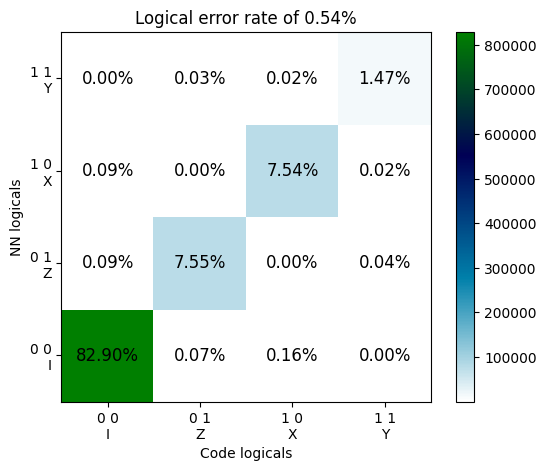

In [50]:
# Calculate the 2d histogram that correlates the actual logicals with the NN prediction
i = 2 * logicals[:, 0] + logicals[:, 1]
j = 2 * NN_logicals[:, 0] + NN_logicals[:, 1]
hist2d = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

labels = ['0 0\nI', '0 1\nZ', '1 0\nX', '1 1\nY']

plt.figure()
img = plt.imshow(hist2d, origin='lower', cmap='ocean_r')
plt.colorbar(img)
plt.xticks(range(4), labels)
plt.yticks(range(4), labels)
plt.xlabel('Code logicals')
plt.ylabel('NN logicals')
for x, row in enumerate(jnp.array(hist2d).T):
    for y, count in enumerate(row):
        plt.text(x, y, f'{count/hist2d.sum():.2%}', ha='center', va='center', rotation=0, rotation_mode='anchor', fontsize=12)
plt.title(f'Logical error rate of {1 - hist2d.diagonal().sum() / hist2d.sum():.2%}')
plt.show()

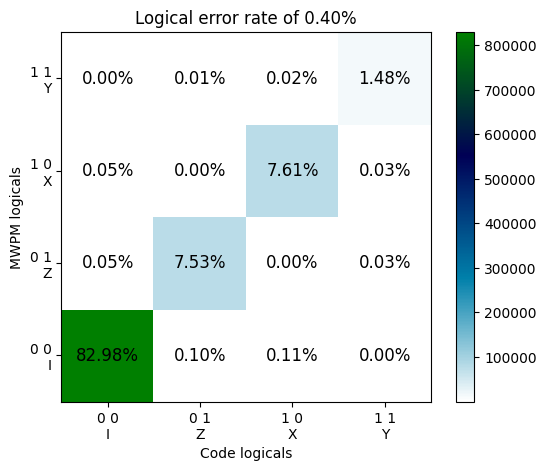

In [51]:
# Calculate the 2d histogram that correlates the actual logicals with the NN prediction
i = 2 * logicals[:, 0] + logicals[:, 1]
j = 2 * MWPM_logicals[:, 0] + MWPM_logicals[:, 1]
hist2d = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

labels = ['0 0\nI', '0 1\nZ', '1 0\nX', '1 1\nY']

plt.figure()
img = plt.imshow(hist2d, origin='lower', cmap='ocean_r')
plt.colorbar(img)
plt.xticks(range(4), labels)
plt.yticks(range(4), labels)
plt.xlabel('Code logicals')
plt.ylabel('MWPM logicals')
for x, row in enumerate(jnp.array(hist2d).T):
    for y, count in enumerate(row):
        plt.text(x, y, f'{count/hist2d.sum():.2%}', ha='center', va='center', rotation=0, rotation_mode='anchor', fontsize=12)
plt.title(f'Logical error rate of {1 - hist2d.diagonal().sum() / hist2d.sum():.2%}')
plt.show()

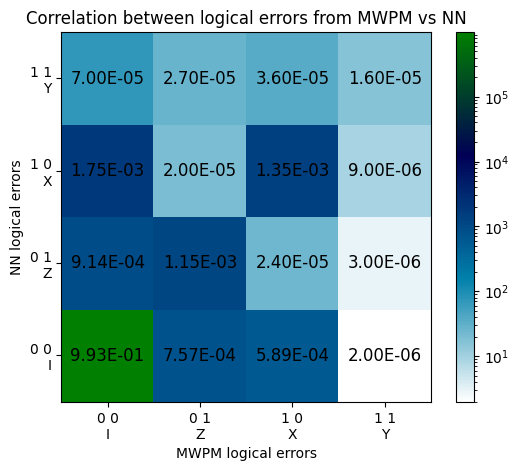

In [52]:
from matplotlib.colors import LogNorm

# Calculate the 2d histogram that correlates the actual logicals with the NN prediction
i = 2 * MWPM_errors[:, 0] + MWPM_errors[:, 1]
j = 2 * NN_errors[:, 0] + NN_errors[:, 1]
hist2d = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

labels = ['0 0\nI', '0 1\nZ', '1 0\nX', '1 1\nY']

plt.figure()
img = plt.imshow(hist2d, origin='lower', cmap='ocean_r', norm=LogNorm())
plt.colorbar(img)
plt.xticks(range(4), labels)
plt.yticks(range(4), labels)
plt.xlabel('MWPM logical errors')
plt.ylabel('NN logical errors')
for x, row in enumerate(jnp.array(hist2d).T):
    for y, count in enumerate(row):
        plt.text(x, y, f'{count/hist2d.sum():7.2E}', ha='center', va='center', rotation=0, rotation_mode='anchor', fontsize=12)
plt.title(f'Correlation between logical errors from MWPM vs NN')
plt.show()

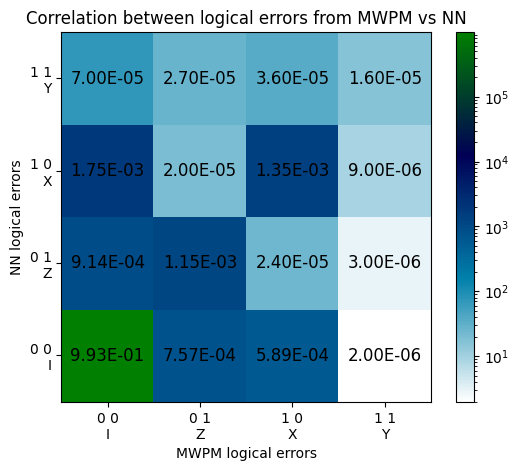

In [ ]:
from matplotlib.colors import LogNorm

# Calculate the 2d histogram that correlates the actual logicals with the NN prediction
i = 2 * MWPM_errors[:, 0] + MWPM_errors[:, 1]
j = 2 * NN_errors[:, 0] + NN_errors[:, 1]
hist2d = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

labels = ['0 0\nI', '0 1\nZ', '1 0\nX', '1 1\nY']

plt.figure()
img = plt.imshow(hist2d, origin='lower', cmap='ocean_r', norm=LogNorm())
plt.colorbar(img)
plt.xticks(range(4), labels)
plt.yticks(range(4), labels)
plt.xlabel('MWPM logical errors')
plt.ylabel('NN logical errors')
for x, row in enumerate(jnp.array(hist2d).T):
    for y, count in enumerate(row):
        plt.text(x, y, f'{count/hist2d.sum():7.2E}', ha='center', va='center', rotation=0, rotation_mode='anchor', fontsize=12)
plt.title(f'Correlation between logical errors from MWPM vs NN')
plt.show()